In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
import shap
import matplotlib.pyplot as plt

In [2]:
df= pd.read_csv('speed_dating_data.csv')
df

,gender,age,income,goal,career,dec,attr,sinc,intel,fun,amb,shar,like,prob,met
0,0,21.0,69487.0,2.0,lawyer,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
1,0,21.0,69487.0,2.0,lawyer,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0
2,0,21.0,69487.0,2.0,lawyer,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN,1.0
3,0,21.0,69487.0,2.0,lawyer,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0,2.0
4,0,21.0,69487.0,2.0,lawyer,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,1,25.0,NaN,1.0,assistant master of the universe (otherwise it...,0,3.0,5.0,5.0,5.0,NaN,NaN,2.0,5.0,0.0
8374,1,25.0,NaN,1.0,assistant master of the universe (otherwise it...,0,4.0,6.0,8.0,4.0,4.0,NaN,4.0,4.0,0.0
8375,1,25.0,NaN,1.0,assistant master of the universe (otherwise it...,0,4.0,7.0,8.0,8.0,8.0,NaN,6.0,5.0,0.0
8376,1,25.0,NaN,1.0,assistant master of the universe (otherwise it...,0,4.0,6.0,5.0,4.0,NaN,5.0,5.0,5.0,0.0


In [3]:
df.columns #target: dec, features: income, attr, sinc, intel, fun, amb, 

Index(['gender', 'age', 'income', 'goal', 'career', 'dec', 'attr', 'sinc',
       'intel', 'fun', 'amb', 'shar', 'like', 'prob', 'met'],
      dtype='object')

In [4]:
df['career'].unique()

array(['lawyer', 'law', 'Economist', 'lawyer/policy work', 'Law',
       'Journalist', 'Congresswoman, and comedian',
       'To create early childhood intervention programs',
       'Academia, Research, Banking, Life', 'Corporate Lawyer', 'Lawyer',
       'Corporate attorney', 'research/financial industry',
       'academics or journalism', 'Financial Services', 'ceo', 'CEO',
       'Undecided', 'Informatics', 'psychologist',
       'health/nutrition oriented social worker', 'Social Worker',
       'Social work with children', 'Speech Language Pathologist', nan,
       'Social Work Administration', 'Professor', "Clidren's TV",
       'Banking', 'Capital Markets', 'Biostatistics',
       'Organizational Change Consultant', 'tech professional',
       'Engineer', 'Academic', 'academia', 'banker / academia', 'banker',
       'Music production', 'Entrepreneur',
       'Intellectual Property Attorney', 'Medicine', 'consulting',
       'LAWYER', 'social worker', 'comedienne', 'attorney',
  

In [5]:
len(df['career'].unique())

368

In [6]:
df.shape

(8378, 15)

In [7]:
df.dtypes

gender      int64
age       float64
income    float64
goal      float64
career     object
dec         int64
attr      float64
sinc      float64
intel     float64
fun       float64
amb       float64
shar      float64
like      float64
prob      float64
met       float64
dtype: object

In [8]:
df['id'] = df.set_index(['gender', 'age', 'income', 'career']).index.factorize()[0]+1

In [9]:
# dropping cols that are partner-dependent or have too many missings
df = df.drop(columns=['income', 'prob', 'shar', 'met'])

In [10]:
average_scores = df.groupby('id')[['attr', 'sinc', 'intel', 'fun', 'amb', 'like']].mean().reset_index()
df = df.groupby('id').first()
df = df.drop(columns = ['attr', 'sinc', 'intel', 'fun', 'amb', 'like']).join(average_scores.set_index('id'), on = 'id')
df

,gender,age,goal,career,dec,attr,sinc,intel,fun,amb,like
id,,,,,,,,,,,
1,0,21.0,2.0,lawyer,1,5.700000,7.300000,7.300000,6.800000,6.300000,6.500000
2,0,24.0,1.0,law,0,6.400000,7.000000,7.700000,6.100000,6.500000,6.600000
3,0,25.0,6.0,Economist,0,8.100000,8.600000,9.400000,7.700000,8.800000,8.200000
4,0,23.0,1.0,lawyer/policy work,0,6.400000,8.900000,8.600000,7.800000,7.800000,6.600000
5,0,21.0,2.0,lawyer,0,6.300000,6.000000,7.000000,6.000000,5.600000,7.200000
...,...,...,...,...,...,...,...,...,...,...,...
535,1,30.0,1.0,Management,1,4.476190,6.714286,5.809524,4.476190,3.904762,5.047619
536,1,28.0,1.0,General management/consulting,0,4.590909,7.045455,6.909091,6.727273,6.863636,5.363636
537,1,30.0,2.0,Finance,0,5.636364,5.954545,5.772727,5.500000,5.045455,5.500000


In [11]:
df.isna().sum()

gender    0
age       4
goal      3
career    4
dec       0
attr      0
sinc      1
intel     1
fun       1
amb       1
like      0
dtype: int64

In [12]:
df= df.dropna()

In [13]:
target = df[['dec']]
features = df.select_dtypes(include=['number'])
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

In [14]:
normalizer = MinMaxScaler()

In [15]:
normalizer.fit(X_train)  

MinMaxScaler()

In [16]:
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [17]:
X_train_norm 

array([[0.        , 0.13888889, 0.2       , ..., 0.72670807, 0.69243421,
        0.72908922],
       [1.        , 0.25      , 0.        , ..., 0.55279503, 0.54605263,
        0.45167286],
       [0.        , 0.08333333, 0.        , ..., 0.64261825, 0.71052632,
        0.52097716],
       ...,
       [1.        , 0.16666667, 0.4       , ..., 0.5119787 , 0.51065163,
        0.53558152],
       [1.        , 0.22222222, 0.2       , ..., 0.2757764 , 0.27631579,
        0.39479554],
       [1.        , 0.08333333, 0.8       , ..., 0.52173913, 0.61687307,
        0.62515489]])

In [18]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_train_norm.head()

,gender,age,goal,dec,attr,sinc,intel,fun,amb,like
0,0.0,0.138889,0.2,0.0,0.793750,0.870283,0.810345,0.726708,0.692434,0.729089
1,1.0,0.250000,0.0,0.0,0.338889,0.591195,0.531034,0.552795,0.546053,0.451673
2,0.0,0.083333,0.0,1.0,0.476190,0.723270,0.696552,0.642618,0.710526,0.520977
3,1.0,0.138889,0.0,0.0,0.522751,0.492662,0.400328,0.479444,0.283208,0.488848
4,1.0,0.083333,1.0,0.0,0.388889,0.631027,0.477395,0.407867,0.388889,0.338910


In [19]:
knn = KNeighborsClassifier(n_neighbors=5)

In [20]:
knn.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [42]:
pred = knn.predict(X_test)  
pred

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1])

In [44]:
y_test.values

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
    

In [46]:
knn.score(X_test, y_test)

0.839622641509434

Using 424 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

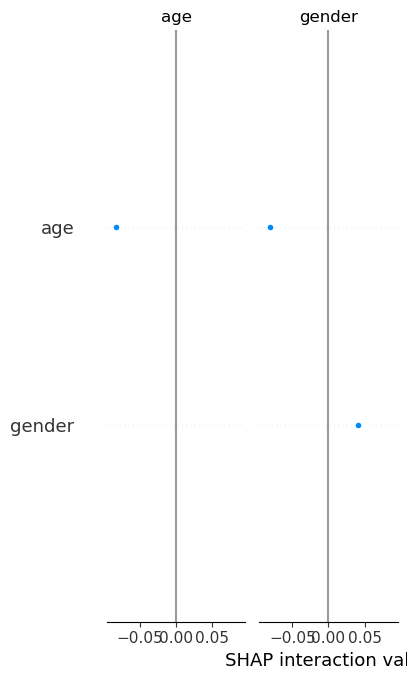

In [64]:
explainer = shap.KernelExplainer(knn.predict_proba, X_train)
shap_values = explainer.shap_values(X_test[:1]) # explain first test instance
plt.figure()
shap.summary_plot(shap_values, X_test[:1], show=False)
plt.savefig("shap.png", dpi=300,bbox_inches='tight')